In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

In [2]:
# jedi 0.14.1 tab completion fails; will be fixed in 0.14.2
import jedi
if jedi.__version__ == '0.14.1':
    %config Completer.use_jedi = False
    
# Progress bar
from tqdm.auto import trange, tqdm

In [3]:
import os
import webbpsf, scipy
from astropy.io import fits
import astropy.units as u

In [4]:
# Import drop models and plot OPD routine
from webbpsf_opd_drift import OTE_WFE_Drift_Model, plot_opd

In [5]:
webbpsf.setup_logging('WARN')

WebbPSF log messages of level WARN and above will be shown.
WebbPSF log outputs will be directed to the screen.


# Initialize OTE Linear Model

In [6]:
webbpsf_path = webbpsf.utils.get_webbpsf_data_path()
pupil_file = 'jwst_pupil_RevW_npix1024.fits.gz'
opd_file = 'OPD_RevW_ote_for_NIRCam_requirements.fits.gz'

pupil_path = os.path.join(webbpsf_path, pupil_file)
opd_path = os.path.join(webbpsf_path, 'NIRCam', 'OPD', opd_file)

name = "Modified OPD from " + str(opd_file)

# Initiate OTE drift class
ote = OTE_WFE_Drift_Model(name=name, opd=opd_path, transmission=pupil_path)

Text(0.5, 0, 'Time (h)')

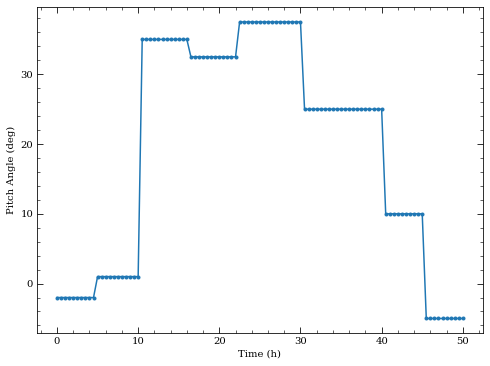

In [7]:
# Create a series of time values to evolve over
tarr = np.linspace(0,50,num=101) # hours

# Convert to astropy units (hrs)
delta_time = tarr * u.hr

# Set case to beginning of life
case = 'BOL'

# Specify telescope pitch angles at each time 
slew_angles = np.zeros_like(tarr, dtype='float')

slew_angles[tarr<5] = -2
slew_angles[tarr>=5] = 1
slew_angles[tarr>10] = 35
slew_angles[tarr>16] = 32.5
slew_angles[tarr>22] = 37.5
slew_angles[tarr>30] = 25
slew_angles[tarr>40] = 10
slew_angles[tarr>45] = -5

plt.plot(delta_time, slew_angles, marker='.')
plt.ylabel('Pitch Angle (deg)')
plt.xlabel(f'Time ({delta_time.unit})')

## Calculate Delta OPDS at each Time Step

In [8]:
# Generate delta OPDs for each time step
# Also outputs a dictionary of each component's WFE drift value (nm RMS)
dopds, wfe_dict = ote.evolve_dopd(delta_time, slew_angles, case=case, return_dopd_fin=True)

In [9]:
# Calculate averages over each slew position
res = ote.slew_pos_averages(delta_time, slew_angles, opds=dopds, wfe_dict=wfe_dict)
dt_new, dopds_new, wfe_dict_new = res

islew = np.where(slew_angles[1:] - slew_angles[:-1] != 0)[0] + 1
islew = np.concatenate(([0], islew))
ang_new = slew_angles[islew]

## Plot RMS drift values over time

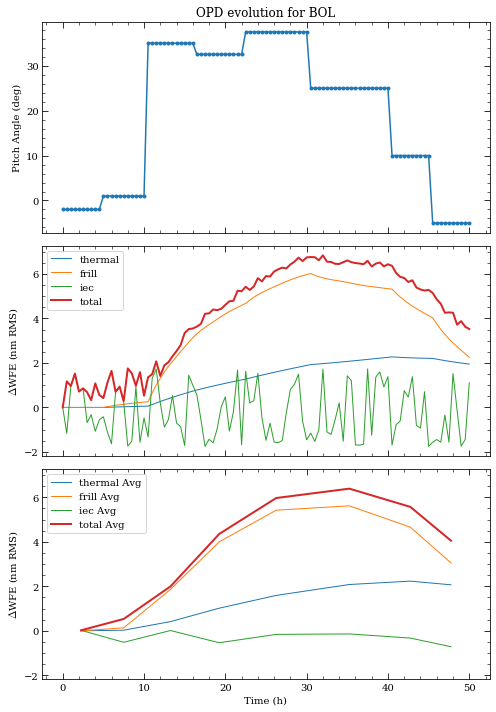

In [10]:
# Plot
fig, axes = plt.subplots(3,1, figsize=(7,10), sharex=True)
axes = axes.flatten()

ax = axes[0]
ax.plot(tarr, slew_angles, marker='.')
ax.set_ylabel('Pitch Angle (deg)')
ax.set_title(f'OPD evolution for {case}')

ax = axes[1]
keys = list(wfe_dict.keys())
for k in keys:
    lw = 2 if 'total' in k else 1
    ax.plot(tarr, wfe_dict[k], label=k, lw=lw)
    
ax = axes[2]
for k in keys:
    lw = 2 if 'total' in k else 1
    ax.plot(dt_new, wfe_dict_new[k], label=f'{k} Avg', lw=lw)
ax.set_xlabel(f'Time ({delta_time.unit})')
ax.set_ylim(axes[1].get_ylim())
    
for ax in axes[1:]:
    ax.legend()
    ax.set_ylabel('$\Delta$WFE (nm RMS)')

fig.tight_layout()

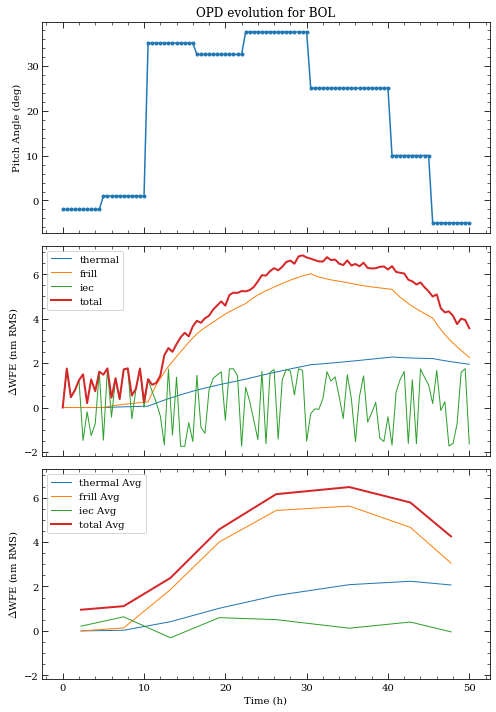

In [10]:
# Plot
fig, axes = plt.subplots(3,1, figsize=(7,10), sharex=True)
axes = axes.flatten()

ax = axes[0]
ax.plot(tarr, slew_angles, marker='.')
ax.set_ylabel('Pitch Angle (deg)')
ax.set_title(f'OPD evolution for {case}')

ax = axes[1]
keys = list(wfe_dict.keys())
for k in keys:
    lw = 2 if 'total' in k else 1
    ax.plot(tarr, wfe_dict[k], label=k, lw=lw)
    
ax = axes[2]
for k in keys:
    lw = 2 if 'total' in k else 1
    ax.plot(dt_new, wfe_dict_new[k], label=f'{k} Avg', lw=lw)
ax.set_xlabel(f'Time ({delta_time.unit})')
ax.set_ylim(axes[1].get_ylim())
    
for ax in axes[1:]:
    ax.legend()
    ax.set_ylabel('$\Delta$WFE (nm RMS)')

fig.tight_layout()

## Convert to HDUList and plot

In [11]:
# Save each slew-averaged OPD to HDUList
# Original OPD is added to each delta OPD
hdul = ote.opds_as_hdul(dt_new, ang_new, delta_opds=dopds_new, wfe_dict=wfe_dict_new, case=case)

In [ ]:
# Plot all OPDs for a given 
for i in range(len(hdul)):
    plot_opd(hdul, index=i, opd0=ote._opd_original, vlim1=400, vlim2=10)

### Can now save OPDs to disk or input into webbpsf instrument instance

In [12]:
inst = webbpsf.NIRCam()
inst.filter = 'F335M'

psf_arr = []
for hdu in tqdm(hdul):
    # Update the Pupil OPD map
    inst.pupilopd = fits.HDUList(hdu)
    
    # Generate PSF
    psf_hdul = inst.calc_psf(add_distortion=False, crop_psf=False)
    psf_im = psf_hdul[0].data
    psf_arr.append(psf_im)
    
psf_arr = np.array(psf_arr)

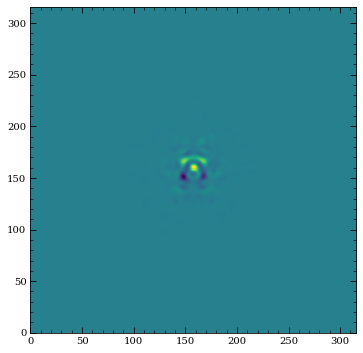

In [13]:
# Plot the PSF difference
plt.imshow(psf_arr[0] - psf_arr[6])